In [18]:
import json
import random
from itertools import combinations
import pandas as pd
import math

import random
import json

def load_random_samples(file_path, sample_size):
    """
    从 JSON 文件中随机抽取指定数量的样本，避免完整遍历文件。
    
    Args:
        file_path (str): JSON 文件路径。
        sample_size (int): 随机抽样的样本数量。

    Returns:
        list: 抽样的记录。
    """
    # 估算文件总行数
    with open(file_path, 'r', encoding='utf-8') as f:
        print("Estimating total lines...")
        total_lines = sum(1 for _ in f)  # 仅计数，不存储内容
        print(f"Total lines: {total_lines}")

    # 随机选择行号
    random_indices = sorted(random.sample(range(total_lines), min(sample_size, total_lines)))

    # 按行号采样
    selected_samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        print("Sampling...")
        current_line = 0
        for target_idx in random_indices:
            while current_line < target_idx:  # 跳过非目标行
                f.readline()
                current_line += 1
            line = f.readline().strip()  # 读取目标行
            selected_samples.append(json.loads(line))
            current_line += 1
        print("Sampling complete.")
    
    return selected_samples

def prepare_data_from_json(samples, same_Scopus_label_ratio=0.5, same_cluster_label_ratio=0.5, total_pairs=1000):
    """
    从 JSON 文件中随机抽样构建数据对，严格控制 same_Scopus_label 和 same_cluster_label 的比例。
    
    Args:
        samples (list): 从JSON中抽取的样本。
        same_Scopus_label_ratio (float): `same_Scopus_label=1` 的目标比例，范围 [0, 1]。
        same_cluster_label_ratio (float): `same_cluster_label=1` 的目标比例，范围 [0, 1]。
        total_pairs (int): 总样本对数量。
        sample_size (int): 每次随机抽取的样本数量。

    Returns:
        pd.DataFrame: 包含 abstract_1, abstract_2, same_Scopus_label, same_cluster_label 的数据集。
    """
    # 检查 sample_size 是否足够生成足够的组合
    sample_size = len(samples)
    max_combinations = math.comb(sample_size, 2)
    if max_combinations < total_pairs:
        raise ValueError(f"Sample size {sample_size} is too small to generate {total_pairs} pairs. "
                         f"Maximum possible pairs with sample size {sample_size} is {max_combinations}.")


    # 计算每种组合的目标数量
    target_counts = {
        (1, 1): int(total_pairs * same_Scopus_label_ratio * same_cluster_label_ratio),
        (1, 0): int(total_pairs * same_Scopus_label_ratio * (1 - same_cluster_label_ratio)),
        (0, 1): int(total_pairs * (1 - same_Scopus_label_ratio) * same_cluster_label_ratio),
        (0, 0): int(total_pairs * (1 - same_Scopus_label_ratio) * (1 - same_cluster_label_ratio)),
    }

    # 初始化存储结果的列表
    pairs = {key: [] for key in target_counts.keys()}

    # 构建数据对
    while not all(len(pairs[k]) == target_counts[k] for k in target_counts.keys()):
        two_row = random.sample(samples, 2)
        row1 = two_row[0]
        row2 = two_row[1]
        Scopus_same = 1 if row1['Scopus_label'] == row2['Scopus_label'] else 0
        cluster_same = 1 if row1['cluster_label'] == row2['cluster_label'] else 0
        pair_key = (Scopus_same, cluster_same)

        # 添加到对应类别
        if len(pairs[pair_key]) < target_counts[pair_key]:
            pairs[pair_key].append({
                "abstract_1": row1["abstract"],
                "abstract_2": row2["abstract"],
                "same_Scopus_label": Scopus_same,
                "same_cluster_label": cluster_same
            })

    # 合并所有组合的数据对
    final_pairs = [pair for key in pairs for pair in pairs[key]]
    random.shuffle(final_pairs)  # 打乱顺序

    return pd.DataFrame(final_pairs)

In [19]:
import sys
sys.path.append("clustering")
import os
from utils import get_data_dir

dataset_path = os.path.join(get_data_dir(), "2010s","dataset.json")

data_dir:  /home/lyuzhuoqi/projects/clustering/data


In [20]:
# 随机抽取样本
samples = load_random_samples(dataset_path, sample_size=10000)

Estimating total lines...
Total lines: 23322430
Sampling...
Sampling complete.


In [21]:
samples

[{'PaperID': 2055220539,
  'abstract': 'Salamanders like newt and axolotl possess the ability to regenerate many of its lost body parts such as limbs, the tail with spinal cord, eye, brain, heart, the jaw 1. Specifically, newts are unique for its lens regeneration capability. Upon lens removal, IPE cells of the dorsal iris transdifferentiate to lens cells and eventually form a new lens in about a month 2,3. This property of regeneration is never exhibited by the ventral iris cells. The regeneration potential of the iris cells can be studied by making transplants of the in vitro cultured IPE cells. For the culture, the dorsal and ventral iris cells are first isolated from the eye and cultured separately for a time period of 2 weeks (Figure 1). These cultured cells are reaggregated and implanted back to the newt eye. Past studies have shown that the dorsal reaggregate maintains its lens forming capacity whereas the ventral aggregate does not form a lens, recapitulating, thus the in vivo 

In [22]:
pair_df = prepare_data_from_json(samples, same_Scopus_label_ratio=0.5, same_cluster_label_ratio=0.5, total_pairs=10000)

In [23]:
pair_df

,abstract_1,abstract_2,same_Scopus_label,same_cluster_label
0,"In this study, a series of high-energy-density...",The crystallization characteristics of CaCO3 m...,1,1
1,Novel building materials were manufactured and...,"We show numerically that a compact structure, ...",0,1
2,Abstract The interest in the energy effici...,The effect of Curcumin partitioning into the b...,0,0
3,The biomechanical properties of Muller glial c...,Relationship among degree on crop disease stre...,0,0
4,We report the case of a patient suffering from...,The HIV rate among U.S. migrant workers is ten...,1,0
...,...,...,...,...
9995,The growing concern for the protection of the ...,The formation of illite through the smectite-t...,0,1
9996,Epithelial Na+ absorption is regulated by Nedd...,Phytocompounds have long been well recognized ...,0,1
9997,Purpose: To compare the functional and ana...,Aim\r\n\r\nTo investigate the diagnosis and ma...,1,0
9998,Fenofibrate is one of the most commonly prescr...,"Recently, the concepts of transverse spin angu...",0,1


In [24]:
pair_df['same_Scopus_label'].value_counts()

same_Scopus_label
1    5000
0    5000
Name: count, dtype: int64

In [25]:
pair_df['same_cluster_label'].value_counts()

same_cluster_label
1    5000
0    5000
Name: count, dtype: int64

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def extract_features(samples, pair_df):
    """
    使用 TF-IDF 提取特征并计算摘要对的组合特征。
    
    Args:
        pair_df (pd.DataFrame): 包含 abstract_1 和 abstract_2 的数据集。

    Returns:
        np.ndarray: 组合特征数组。
    """
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    # 将所有摘要拼接用于训练 TF-IDF
    all_abstracts = [sample['abstract'] for sample in samples]
    vectorizer.fit(all_abstracts)

    # 计算组合特征（可以尝试其他方法）
    tfidf_abstract_1 = vectorizer.transform(pair_df['abstract_1'])
    tfidf_abstract_2 = vectorizer.transform(pair_df['abstract_2'])
    sum_features = tfidf_abstract_1 + tfidf_abstract_2
    diff_features = np.abs(tfidf_abstract_1 - tfidf_abstract_2)
    cosine_features = cosine_similarity(tfidf_abstract_1, tfidf_abstract_2).diagonal().reshape(-1, 1)
    
    # 拼接特征
    combined_features = np.hstack([sum_features.toarray(), diff_features.toarray(), cosine_features])
    return combined_features

In [27]:
# feature extraction using tf-idf, shared by all models
X = extract_features(samples, pair_df)

In [28]:
from sklearn.model_selection import train_test_split
label_column = "same_Scopus_label"

y = pair_df[label_column]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0       0.65      0.76      0.70       963
           1       0.74      0.62      0.67      1037

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.70      0.69      0.69      2000



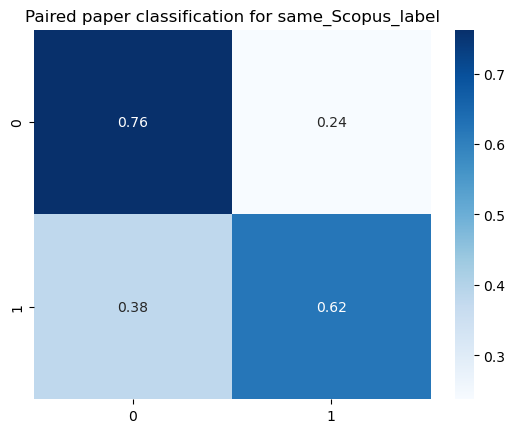

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
# evluation
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title(f"Paired paper classification for {label_column}")
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
label_column = "same_cluster_label"

y = pair_df[label_column]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0       0.62      0.70      0.65       964
           1       0.68      0.60      0.64      1036

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.65      0.64      0.64      2000



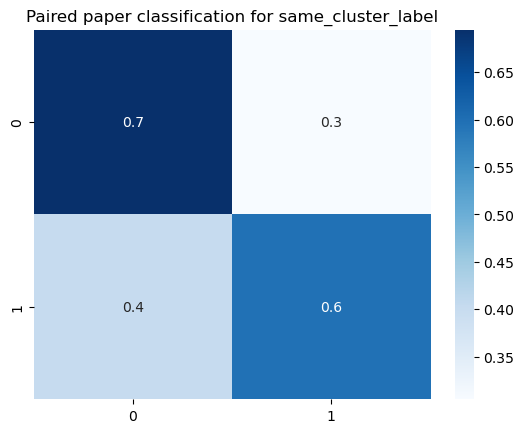

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 评估模型性能
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title(f"Paired paper classification for {label_column}")
plt.show()